In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("AER_credit_card_data.csv")
df.describe()

,reports,age,income,share,expenditure,dependents,months,majorcards,active
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.456406,33.213103,3.365376,0.068732,185.057071,0.993935,55.267627,0.817286,6.996967
std,1.345267,10.142783,1.693902,0.094656,272.218917,1.247745,66.271746,0.386579,6.305812
min,0.000000,0.166667,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.416670,2.243750,0.002316,4.583333,0.000000,12.000000,1.000000,2.000000
50%,0.000000,31.250000,2.900000,0.038827,101.298300,1.000000,30.000000,1.000000,6.000000
75%,0.000000,39.416670,4.000000,0.093617,249.035800,2.000000,72.000000,1.000000,11.000000
max,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000


In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
df.card = (df.card =='yes').astype(int)

In [5]:
df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [6]:
df_fulltrain,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_fulltrain,test_size=0.25,random_state=1)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']


In [7]:
numerical = ['reports', 'age', 'income', 'share', 'expenditure','dependents', 'months', 'active']
categorial = ['owner','selfemp','majorcards']

## Question 1
Question 1: Feature with highest ROC AUC
- reports
- dependents
- active
- share

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [9]:
for s in numerical:
    auc = roc_auc_score(y_train, df_train[s])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[s])
    print('%11s, %.3f' % (s, auc))

    reports, 0.717
        age, 0.524
     income, 0.591
      share, 0.989
expenditure, 0.991
 dependents, 0.533
     months, 0.529
     active, 0.604


Which numerical variable (among the following 4) has the highest AUC?

reports
dependents
active
share

### Answer : share has the highest AUC

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [10]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model  = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)
y_pred = model.predict_proba(X_val)[:, 1]

In [11]:
round(roc_auc_score(y_val,y_pred),3)

0.995

### Answer : AUC of this model on the validation dataset is 0.995

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

In [12]:
def pre_recall_df(y_val,y_pred):
    scores = []
    thresholds = np.linspace(0,1,101)
    thresholds
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    cols = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=cols)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    return df_scores

In [13]:
df_scores = pre_recall_df(y_val,y_pred)

In [14]:
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,211,53,0,0,0.799242,1.000000
10,0.1,210,17,1,36,0.925110,0.995261
20,0.2,207,5,4,48,0.976415,0.981043
30,0.3,205,5,6,48,0.976190,0.971564
40,0.4,205,1,6,52,0.995146,0.971564
50,0.5,204,1,7,52,0.995122,0.966825
60,0.6,204,1,7,52,0.995122,0.966825
70,0.7,204,1,7,52,0.995122,0.966825
80,0.8,204,1,7,52,0.995122,0.966825
90,0.9,204,0,7,53,1.000000,0.966825


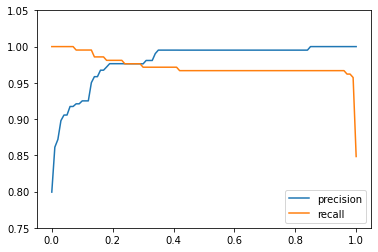

In [15]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.ylim(0.75,1.05)
plt.legend()
plt.show()

### Answer: precision and recall curves intersect at threshold of 0.3

## Question 4

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [16]:
df_scores['f1'] = 2*df_scores.precision*df_scores.recall/(df_scores.precision+df_scores.recall)

In [17]:
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.0,211,53,0,0,0.799242,1.000000,0.888421
10,0.1,210,17,1,36,0.925110,0.995261,0.958904
20,0.2,207,5,4,48,0.976415,0.981043,0.978723
30,0.3,205,5,6,48,0.976190,0.971564,0.973872
40,0.4,205,1,6,52,0.995146,0.971564,0.983213
50,0.5,204,1,7,52,0.995122,0.966825,0.980769
60,0.6,204,1,7,52,0.995122,0.966825,0.980769
70,0.7,204,1,7,52,0.995122,0.966825,0.980769
80,0.8,204,1,7,52,0.995122,0.966825,0.980769
90,0.9,204,0,7,53,1.000000,0.966825,0.983133


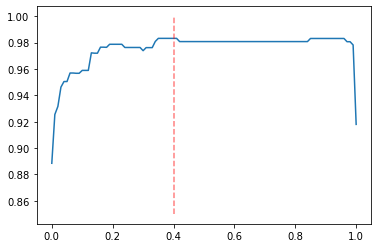

In [18]:
plt.plot(df_scores.threshold, df_scores.f1, label='F1 score')
plt.vlines(0.4, 0.85, 1, color='red', linestyle='--', alpha=0.5)


### Answer: At 0.4 threshold F1 is maximal.


## Question 5

How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [19]:
from sklearn.model_selection import KFold

In [20]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [21]:
def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [22]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_fulltrain):
    df_train = df_fulltrain.iloc[train_idx]
    df_val = df_fulltrain.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


### The Standard devidation of the AUC scores across different folds is 0.003

## Question 6

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for c in [0.01, 0.1, 1, 10]:
    scores = []
    for train_idx, val_idx in kfold.split(df_fulltrain):
        df_train = df_fulltrain.iloc[train_idx]
        df_val = df_fulltrain.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

C=0.01 0.996 +- 0.003
C=0.1 0.996 +- 0.003
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


### Answer: As all the C have same mean score. least c value of 0.01 is considered.